In [9]:
# 1. Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 2. Загрузка датасета
df = pd.read_csv('S05-hw-dataset.csv')

# 3. Анализ датасета
print(df.head())
print(df.info())
print(df.describe())

target_distribution = df['default'].value_counts(normalize=True)
print(target_distribution)

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

In [10]:
#Выделяем матрицу признаков X и y
X = df.drop(columns=['default', 'client_id'])
y = df['default']

print(f"\nРазмер матрицы X: {X.shape}")
print(f"Размер вектора y: {y.shape}")

# 2. Проверка debt_to_income [0, 1]
debt_invalid = X[(X['debt_to_income'] < 0) | (X['debt_to_income'] > 1)]
if not debt_invalid.empty:
    print(f"Найдено {len(debt_invalid)} записей с debt_to_income не в диапазоне [0, 1]")

if X.select_dtypes(include=['object']).empty:
    print("Все признаки числовые")
else:
    print("Есть нечисловые признаки")


Размер матрицы X: (3000, 15)
Размер вектора y: (3000,)
Все признаки числовые


In [11]:
#Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=56, 
    stratify=y
)

# 2. Бейзлайн
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

# 3. Оценка бейзлайна
y_pred = baseline.predict(X_test)
accuracy9 = accuracy_score(y_test, y_pred)

y_pred_proba = baseline.predict_proba(X_test)[:, 1]
roc_auc9 = roc_auc_score(y_test, y_pred_proba)

print(accuracy9)
print(roc_auc9)

0.59
0.5


0.8033333333333333 0.877451655872491 1.0


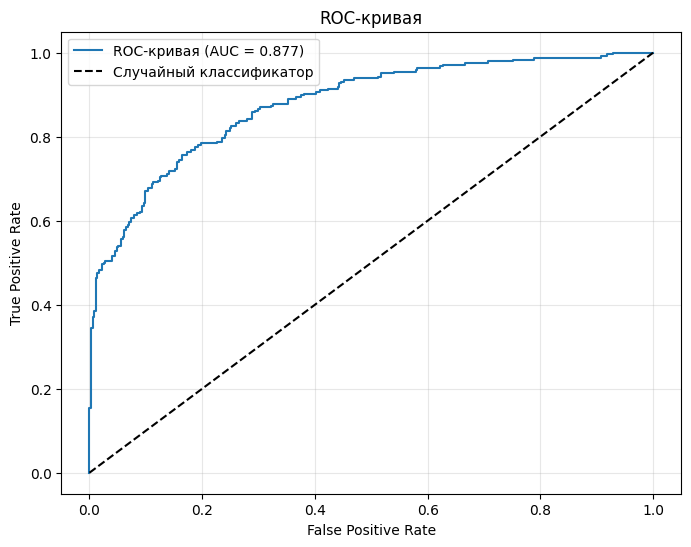

In [12]:
# Создание Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Подбор параметра C
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0]}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Предсказания
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
accuracy2 = accuracy_score(y_test, y_pred)
roc_auc2 = roc_auc_score(y_test, y_pred_proba)
best_param = grid_search.best_params_['logreg__C']
print(accuracy2,roc_auc2,best_param)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc2:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('./figures/roc_curve.png', dpi=100, bbox_inches='tight')

In [13]:
results = pd.DataFrame({
    'Модель': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [accuracy9, accuracy2],
    'ROC-AUC': [roc_auc9, roc_auc2]
})

print("Сравнение моделей:")
print(results.to_string(index=False))

Сравнение моделей:
            Модель  Accuracy  ROC-AUC
   DummyClassifier  0.590000 0.500000
LogisticRegression  0.803333 0.877452


In [ ]:
##   Целевая переменная распределена с умеренным дисбалансом: 59% без дефолта, 41% с дефолтом.
##   - DummyClassifier с strategy='most_frequent' показал accuracy 0.5917, что соответствует доле самого частого класса.
##   - ROC-AUC = 0.5 подтверждает, что модель не обладает предсказательной способностью.
##   - Лучший параметр регуляризации C=1.0 обеспечивает баланс между недообучением и переобучением.
##   - Качество значительно улучшилось: accuracy выросла на ~20% (до 0.7983), ROC-AUC достиг 0.8763.
##   - Оптимальное значение C=1.0 показывает лучший компромисс
##   - Логистическая регрессия является эффективным решением для этой задачи.
##   - Модель значительно превосходит бейзлайн, что подтверждает наличие полезных закономерностей в данных.